## Filter Operations

In this section, we will demonstrate three filter operations on CCI ECV datasets:

1. Filtering a dataset based on a specific flag value.
2. Filtering, exploring, and propagating uncertainties that accompany the dataset.
3. Filtering based on any data feature.

All of these filter operations are performed using the [`xarray.Dataset.where`](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.where.html) method, which is fully compatible with [Dask](https://www.dask.org/). This approach allows for on-demand filtering, performed chunk-by-chunk for efficiency.

---
### 1. Filtering a datset for a given flag value

We will show this filtering operation on a soil moisture dataset, which comes with a quality flag for its observational data.  

In [1]:
import matplotlib.pyplot as plt
from xcube.core.store import new_data_store

We can access the soil moisture dataset through the Zarr data store, as shown below:

In [2]:
store = new_data_store('esa-cci-zarr')

In [3]:
ds = store.open_data("ESACCI-SOILMOISTURE-L3S-SSMV-COMBINED-1978-2021-fv07.1.zarr")
ds

<xarray.Dataset> Size: 654GB
Dimensions:         (time: 15767, lat: 720, lon: 1440)
Coordinates:
  * lat             (lat) float64 6kB 89.88 89.62 89.38 ... -89.38 -89.62 -89.88
  * lon             (lon) float64 12kB -179.9 -179.6 -179.4 ... 179.6 179.9
  * time            (time) datetime64[ns] 126kB 1978-11-01 ... 2021-12-31
Data variables:
    dnflag          (time, lat, lon) float32 65GB dask.array<chunksize=(16, 720, 720), meta=np.ndarray>
    flag            (time, lat, lon) float32 65GB dask.array<chunksize=(16, 720, 720), meta=np.ndarray>
    freqbandID      (time, lat, lon) float32 65GB dask.array<chunksize=(16, 720, 720), meta=np.ndarray>
    mode            (time, lat, lon) float32 65GB dask.array<chunksize=(16, 720, 720), meta=np.ndarray>
    sensor          (time, lat, lon) float64 131GB dask.array<chunksize=(16, 720, 720), meta=np.ndarray>
    sm              (time, lat, lon) float32 65GB dask.array<chunksize=(16, 720, 720), meta=np.ndarray>
    sm_uncertainty  (time, lat, lon) float32 65GB dask.array<chunksize=(16, 720, 720), meta=np.ndarray>
    t0              (time, lat, lon) float64 131GB dask.array<chunksize=(16, 720, 720), meta=np.ndarray>
Attributes: (12/44)
    Conventions:                  CF-1.9
    cdm_data_type:                Grid
    comment:                      This dataset was produced with funding of t...
    contact:                      cci_sm_contact@eodc.eu
    creator_email:                cci_sm_developer@eodc.eu
    creator_name:                 Department of Geodesy and Geoinformation, V...
    ...                           ...
    time_coverage_end_product:    20211231T235959Z
    time_coverage_resolution:     P1D
    time_coverage_start:          1978-11-01 00:00:00
    time_coverage_start_product:  19781101T000000Z
    title:                        ESA CCI Surface Soil Moisture COMBINED acti...
    tracking_id:                  ad35798e-58e0-488f-b5b9-593874a47700

We can filter the soil moisture data using the `"no_data_inconsistency_detected"` flag, which corresponds to a flag value of `0` in the `flag` data variable. This value can be verified by checking the attributes of the `flag` variable.


In [4]:
filtered_ds = ds.where(ds["flag"] != 0)
filtered_ds

<xarray.Dataset> Size: 654GB
Dimensions:         (time: 15767, lat: 720, lon: 1440)
Coordinates:
  * lat             (lat) float64 6kB 89.88 89.62 89.38 ... -89.38 -89.62 -89.88
  * lon             (lon) float64 12kB -179.9 -179.6 -179.4 ... 179.6 179.9
  * time            (time) datetime64[ns] 126kB 1978-11-01 ... 2021-12-31
Data variables:
    dnflag          (time, lat, lon) float32 65GB dask.array<chunksize=(16, 720, 720), meta=np.ndarray>
    flag            (time, lat, lon) float32 65GB dask.array<chunksize=(16, 720, 720), meta=np.ndarray>
    freqbandID      (time, lat, lon) float32 65GB dask.array<chunksize=(16, 720, 720), meta=np.ndarray>
    mode            (time, lat, lon) float32 65GB dask.array<chunksize=(16, 720, 720), meta=np.ndarray>
    sensor          (time, lat, lon) float64 131GB dask.array<chunksize=(16, 720, 720), meta=np.ndarray>
    sm              (time, lat, lon) float32 65GB dask.array<chunksize=(16, 720, 720), meta=np.ndarray>
    sm_uncertainty  (time, lat, lon) float32 65GB dask.array<chunksize=(16, 720, 720), meta=np.ndarray>
    t0              (time, lat, lon) float64 131GB dask.array<chunksize=(16, 720, 720), meta=np.ndarray>
Attributes: (12/44)
    Conventions:                  CF-1.9
    cdm_data_type:                Grid
    comment:                      This dataset was produced with funding of t...
    contact:                      cci_sm_contact@eodc.eu
    creator_email:                cci_sm_developer@eodc.eu
    creator_name:                 Department of Geodesy and Geoinformation, V...
    ...                           ...
    time_coverage_end_product:    20211231T235959Z
    time_coverage_resolution:     P1D
    time_coverage_start:          1978-11-01 00:00:00
    time_coverage_start_product:  19781101T000000Z
    title:                        ESA CCI Surface Soil Moisture COMBINED acti...
    tracking_id:                  ad35798e-58e0-488f-b5b9-593874a47700

We can generate a comparison plot that illustrates both the unfiltered and filtered soil moisture at a single time step as an example.

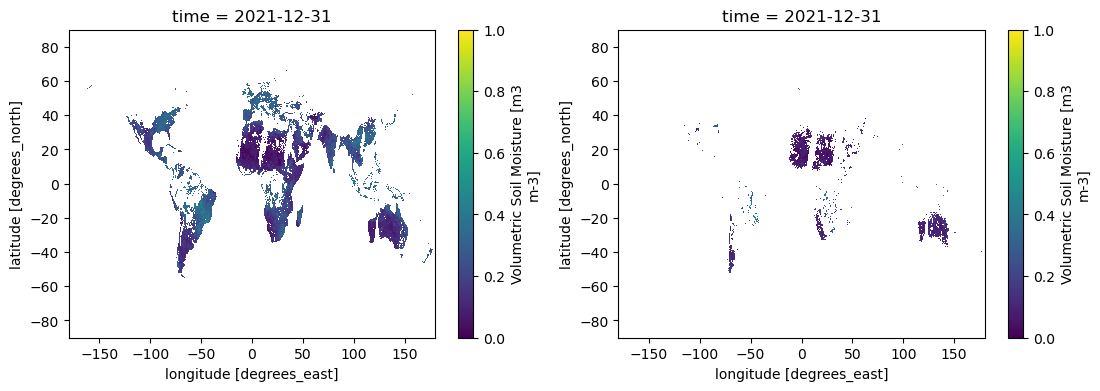

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(13, 4))
ds.sm.isel(time=-1).plot(ax=ax[0], vmin=0, vmax=1)
filtered_ds.sm.isel(time=-1).plot(ax=ax[1], vmin=0, vmax=1)

---
### 2. Filtering based on uncertainties that accompany a dataset

We will show this filtering operation on a biomass dataset, which carries uncertainty values for the above-ground biomass data in the `"abg_se"` (long name `"Above-ground biomass standard_error"`) data variable. 

In [6]:
ds = store.open_data('ESACCI-BIOMASS-L4-AGB-MERGED-100m-2010-2020-fv4.0.zarr')
ds

<xarray.Dataset> Size: 3TB
Dimensions:    (time: 5, lat: 157500, lon: 405000, nv: 2)
Coordinates:
  * lat        (lat) float64 1MB 80.0 80.0 80.0 80.0 ... -60.0 -60.0 -60.0 -60.0
    lat_bnds   (lat, nv) float64 3MB dask.array<chunksize=(1575, 2), meta=np.ndarray>
  * lon        (lon) float64 3MB -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
    lon_bnds   (lon, nv) float64 6MB dask.array<chunksize=(2025, 2), meta=np.ndarray>
  * time       (time) datetime64[ns] 40B 2010-07-02 2017-07-02 ... 2020-07-01
    time_bnds  (time, nv) datetime64[ns] 80B dask.array<chunksize=(1, 2), meta=np.ndarray>
Dimensions without coordinates: nv
Data variables:
    agb        (time, lat, lon) float32 1TB dask.array<chunksize=(1, 1575, 2025), meta=np.ndarray>
    agb_se     (time, lat, lon) float32 1TB dask.array<chunksize=(1, 1575, 2025), meta=np.ndarray>
Attributes: (12/53)
    Conventions:                  CF-1.7
    EPSG:                         4326
    GeoTransform:                 -180   0.00088888888888                  0 ...
    catalogue_url:                https://catalogue.ceda.ac.uk/uuid/84403d09c...
    cdm_data_type:                INT
    comment:                      These data were produced at ESA CCI as part...
    ...                           ...
    time_coverage_duration:       P1Y
    time_coverage_end:            20201231T000000Z
    time_coverage_resolution:     P1Y
    time_coverage_start:          20100101T000000Z
    title:                        ESA CCI above-ground biomass product level ...
    tracking_id:                  cd5cb1d2-e582-41ab-a0fc-637f050baf9e

Since the dataset is quite large, we have selected the Tropical Climate Zone (TCL) in Africa for analysis. This region is known for its high biological activity and consequently high values of above-ground biomass.

It’s important to note that the filtering method works efficiently on the full dataset. This is because the `xarray.Dataset.where` operation is performed on demand, either when writing or plotting the data. However, without selecting a smaller subset like the TCL Zone, performance issues will arise during plotting.

In [7]:
ds = ds.sel(lat=slice(10, -10), lon=slice(10, 40))
ds

<xarray.Dataset> Size: 30GB
Dimensions:    (time: 5, lat: 22500, lon: 33750, nv: 2)
Coordinates:
  * lat        (lat) float64 180kB 10.0 9.999 9.998 ... -9.998 -9.999 -10.0
    lat_bnds   (lat, nv) float64 360kB dask.array<chunksize=(1575, 2), meta=np.ndarray>
  * lon        (lon) float64 270kB 10.0 10.0 10.0 10.0 ... 40.0 40.0 40.0 40.0
    lon_bnds   (lon, nv) float64 540kB dask.array<chunksize=(900, 2), meta=np.ndarray>
  * time       (time) datetime64[ns] 40B 2010-07-02 2017-07-02 ... 2020-07-01
    time_bnds  (time, nv) datetime64[ns] 80B dask.array<chunksize=(1, 2), meta=np.ndarray>
Dimensions without coordinates: nv
Data variables:
    agb        (time, lat, lon) float32 15GB dask.array<chunksize=(1, 1575, 900), meta=np.ndarray>
    agb_se     (time, lat, lon) float32 15GB dask.array<chunksize=(1, 1575, 900), meta=np.ndarray>
Attributes: (12/53)
    Conventions:                  CF-1.7
    EPSG:                         4326
    GeoTransform:                 -180   0.00088888888888                  0 ...
    catalogue_url:                https://catalogue.ceda.ac.uk/uuid/84403d09c...
    cdm_data_type:                INT
    comment:                      These data were produced at ESA CCI as part...
    ...                           ...
    time_coverage_duration:       P1Y
    time_coverage_end:            20201231T000000Z
    time_coverage_resolution:     P1Y
    time_coverage_start:          20100101T000000Z
    title:                        ESA CCI above-ground biomass product level ...
    tracking_id:                  cd5cb1d2-e582-41ab-a0fc-637f050baf9e

Where filter the dataset for standard error smaller than 100 Mg/ha.

In [8]:
filtered_ds = ds.where(ds["agb_se"] <= 100)
filtered_ds

<xarray.Dataset> Size: 30GB
Dimensions:    (time: 5, lat: 22500, lon: 33750, nv: 2)
Coordinates:
  * lat        (lat) float64 180kB 10.0 9.999 9.998 ... -9.998 -9.999 -10.0
    lat_bnds   (lat, nv) float64 360kB dask.array<chunksize=(1575, 2), meta=np.ndarray>
  * lon        (lon) float64 270kB 10.0 10.0 10.0 10.0 ... 40.0 40.0 40.0 40.0
    lon_bnds   (lon, nv) float64 540kB dask.array<chunksize=(900, 2), meta=np.ndarray>
  * time       (time) datetime64[ns] 40B 2010-07-02 2017-07-02 ... 2020-07-01
    time_bnds  (time, nv) datetime64[ns] 80B dask.array<chunksize=(1, 2), meta=np.ndarray>
Dimensions without coordinates: nv
Data variables:
    agb        (time, lat, lon) float32 15GB dask.array<chunksize=(1, 1575, 900), meta=np.ndarray>
    agb_se     (time, lat, lon) float32 15GB dask.array<chunksize=(1, 1575, 900), meta=np.ndarray>
Attributes: (12/53)
    Conventions:                  CF-1.7
    EPSG:                         4326
    GeoTransform:                 -180   0.00088888888888                  0 ...
    catalogue_url:                https://catalogue.ceda.ac.uk/uuid/84403d09c...
    cdm_data_type:                INT
    comment:                      These data were produced at ESA CCI as part...
    ...                           ...
    time_coverage_duration:       P1Y
    time_coverage_end:            20201231T000000Z
    time_coverage_resolution:     P1Y
    time_coverage_start:          20100101T000000Z
    title:                        ESA CCI above-ground biomass product level ...
    tracking_id:                  cd5cb1d2-e582-41ab-a0fc-637f050baf9e

We can generate a comparison plot that illustrates both the unfiltered and filtered above-ground biomass at a single time step as an example. Also here we downsample the dataset for the plotting. 

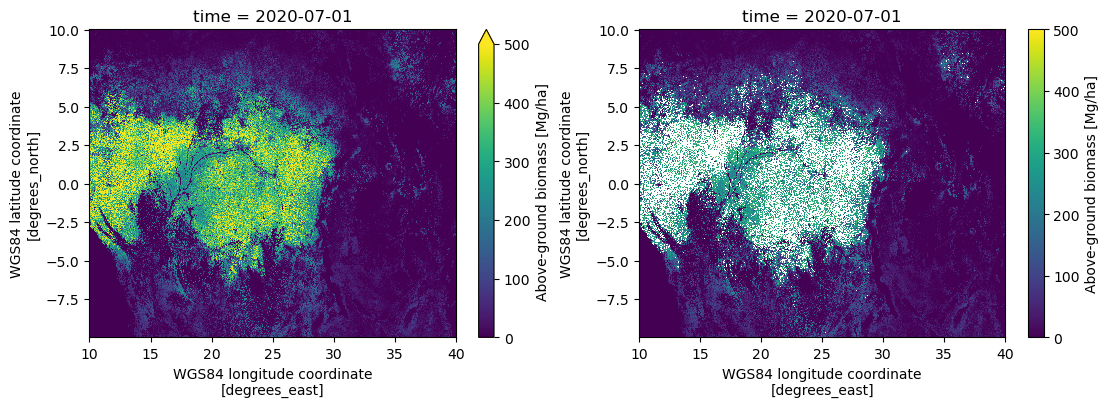

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(13, 4))
ds.agb.isel(time=-1)[::20, ::20].plot(ax=ax[0], vmin=0, vmax=500)
filtered_ds.agb.isel(time=-1)[::20, ::20].plot(ax=ax[1], vmin=0, vmax=500)

---
### 3. Filtering by any data feature

We will show this filtering operation on the soil moisture dataset, which also has other data variables which can be used for filtering.  

In [10]:
ds = store.open_data("ESACCI-SOILMOISTURE-L3S-SSMV-COMBINED-1978-2021-fv07.1.zarr")
ds

<xarray.Dataset> Size: 654GB
Dimensions:         (time: 15767, lat: 720, lon: 1440)
Coordinates:
  * lat             (lat) float64 6kB 89.88 89.62 89.38 ... -89.38 -89.62 -89.88
  * lon             (lon) float64 12kB -179.9 -179.6 -179.4 ... 179.6 179.9
  * time            (time) datetime64[ns] 126kB 1978-11-01 ... 2021-12-31
Data variables:
    dnflag          (time, lat, lon) float32 65GB dask.array<chunksize=(16, 720, 720), meta=np.ndarray>
    flag            (time, lat, lon) float32 65GB dask.array<chunksize=(16, 720, 720), meta=np.ndarray>
    freqbandID      (time, lat, lon) float32 65GB dask.array<chunksize=(16, 720, 720), meta=np.ndarray>
    mode            (time, lat, lon) float32 65GB dask.array<chunksize=(16, 720, 720), meta=np.ndarray>
    sensor          (time, lat, lon) float64 131GB dask.array<chunksize=(16, 720, 720), meta=np.ndarray>
    sm              (time, lat, lon) float32 65GB dask.array<chunksize=(16, 720, 720), meta=np.ndarray>
    sm_uncertainty  (time, lat, lon) float32 65GB dask.array<chunksize=(16, 720, 720), meta=np.ndarray>
    t0              (time, lat, lon) float64 131GB dask.array<chunksize=(16, 720, 720), meta=np.ndarray>
Attributes: (12/44)
    Conventions:                  CF-1.9
    cdm_data_type:                Grid
    comment:                      This dataset was produced with funding of t...
    contact:                      cci_sm_contact@eodc.eu
    creator_email:                cci_sm_developer@eodc.eu
    creator_name:                 Department of Geodesy and Geoinformation, V...
    ...                           ...
    time_coverage_end_product:    20211231T235959Z
    time_coverage_resolution:     P1D
    time_coverage_start:          1978-11-01 00:00:00
    time_coverage_start_product:  19781101T000000Z
    title:                        ESA CCI Surface Soil Moisture COMBINED acti...
    tracking_id:                  ad35798e-58e0-488f-b5b9-593874a47700

For example, we can use the data variable `"mode"`, which indicates whether the observation is derived from the ascending or descending orbit. This variable can be used to filter the dataset, allowing us to select only the ascending mode, represented by `1`, and the descending mode, represented by `2`, and  as shown below:

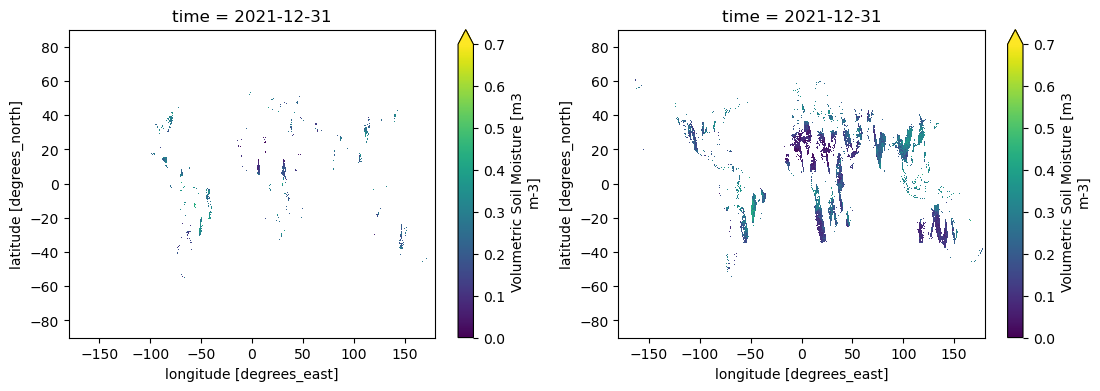

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(13, 4))
ds.where(ds["mode"] == 1).sm.isel(time=-1).plot(ax=ax[0], vmin=0, vmax=0.7)
ds.where(ds["mode"] == 2).sm.isel(time=-1).plot(ax=ax[1], vmin=0, vmax=0.7)

We can easliy generate the same plot for the soil moisture uncertainty data variable. 

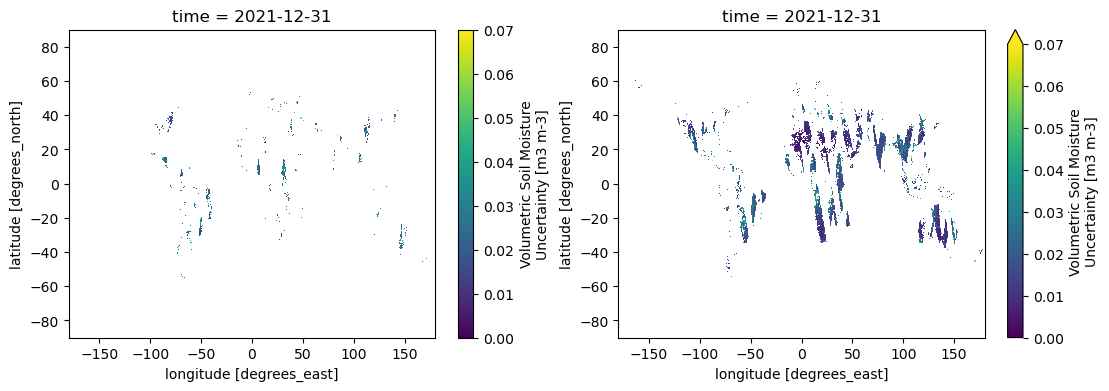

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(13, 4))
ds.where(ds["mode"] == 1).sm_uncertainty.isel(time=-1).plot(ax=ax[0], vmin=0, vmax=0.07)
ds.where(ds["mode"] == 2).sm_uncertainty.isel(time=-1).plot(ax=ax[1], vmin=0, vmax=0.07)